(ch:extended)=
# Extended Source Photometry

We learned 2-D background estimations using ``photutils`` and ``sep``, which are mere pyhonically ported SExtractor. The goal of SExtractor is, as explained earlier, to extract an arbitrary source (star, galaxy, ...) from the image.

Here we will explore this **source extraction** part of them. 

```{important} 
Before proceeding, I expect you to read and follow the documentation and tutorials:
1. [photutils/Image Segmentation](https://photutils.readthedocs.io/en/stable/segmentation.html) 
    * Image convolution and source detection
    * Source deblending
    * `SourceCatalog` class & extended source photometry
2. [photutils/morphology](https://photutils.readthedocs.io/en/stable/morphology.html)
    * Read this with `SourceCatalog` above.
3. [photutils/ELLIPSE Isophote analysis](https://photutils.readthedocs.io/en/stable/isophote.html)
    * This is the implementation of STSDAS.ISOPHOT.ELLIPSE package into Python by Ivo Busko.
    * If you are planning on doing research on galaxies, you may also want to take a look at [additional notebooks](https://photutils.readthedocs.io/en/stable/isophote.html#additional-example-notebooks-online). Note that these were last updated in Jan. 2021, so some code lines will not work properly. 
    * Another reference: Jedrzejewski (1987; MNRAS 226, 747). 
4. You may also refer to all the remaining parts of [sep documentations](https://sep.readthedocs.io/en/v1.1.x/tutorial.html#Object-detection).
```

This lecture note is built on top of them (i.e., I expect you to have at least brief knowledge of all of them and will not explain further details). 

In [2]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-07-11 20:45:09 (KST = GMT+0900) 
0 Python     3.10.11 64bit [Clang 14.0.6 ]
1 IPython    8.14.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.3
4 numpy      1.24.3
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8639
8 photutils  1.8.0
9 version_information 1.0.4


In [6]:
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import _tool_visualization as vis
import numpy as np
import scipy.special as ss
import ysfitsutilpy as yfu
import ysphotutilpy as ypu
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats
from astropy.table import Table
from astropy.visualization.wcsaxes import add_scalebar
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

from photutils import Background2D, EllipticalAperture
from photutils.aperture import (EllipticalAnnulus, EllipticalAperture, 
                                CircularAperture, CircularAnnulus)
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
from photutils.segmentation import deblend_sources, detect_sources

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path("../../Tutorial_Data")
ccd_orig = CCDData.read(DATAPATH / "ngc1132_r.fits")
pos_init = (1260, 485)
cut = Cutout2D(ccd_orig, position=pos_init, size=(251, 251))
data_orig = ccd_orig.data
data = cut.data

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_44661/3386884007.py:36: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, EllipticalAperture
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_44661/3386884007.py:36: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import Background2D, EllipticalAperture
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


We will explore one of the SDSS image around a galaxy, [NGC1132](https://en.wikipedia.org/wiki/NGC_1132). 

```{tip} 
For plotting, I have extensively used astropy's WCSAxes. You can refer to [astropy/visualization/WCSAxes](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) and try various settings for fun!
```

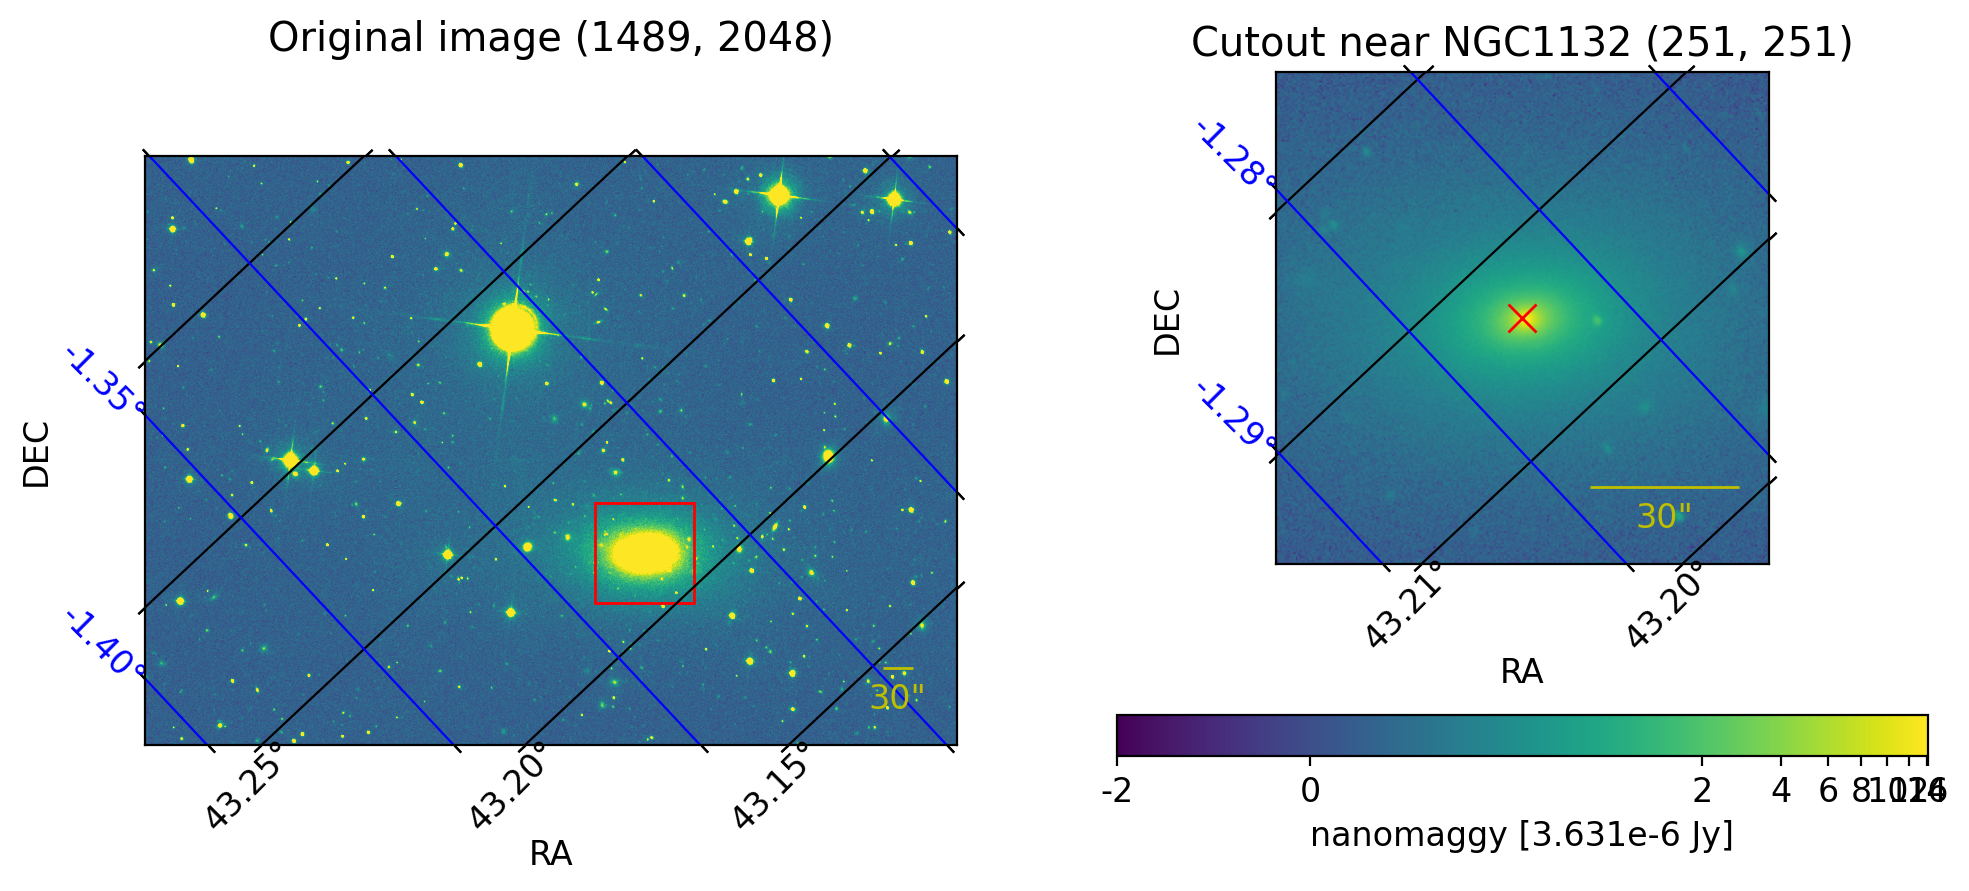

In [2]:
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot(121, projection=ccd_orig.wcs)
ax1 = plt.subplot(122, projection=cut.wcs)

vis.norm_imshow(ax0, data_orig, zscale=True)
im = vis.norm_imshow(ax1, data, stretch="log", log_a=1000)
vis.colorbaring(fig, ax1, im, fmt="%.0f", pad=0.2, label="nanomaggy [3.631e-6 Jy]")
for i, (ax, sp) in enumerate(zip([ax0, ax1], [0.05, 0.01])):
    lon, lat = ax.coords
    lon.set_axislabel("RA", minpad=0.5)
    lat.set_axislabel("DEC", minpad=0.5)
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks(spacing=sp*u.deg)  # or, e.g., number=4
    lat.set_ticks(spacing=sp*u.deg) 
    lon.set_ticklabel(color='k', rotation=45, ha='left', va="bottom", rotation_mode='anchor')
    lat.set_ticklabel(color='b', rotation=-45, ha='left', va="bottom", rotation_mode='anchor')
    lon.grid(True, color='k', ls='-')
    lat.grid(True, color='b', ls='-')
    add_scalebar(ax, length=30*u.arcsec, color='y', label='30"', corner='bottom right')
    # lon.set_ticks_position('bt')
    # lon.set_ticklabel_position('bt')
    # lon.set_axislabel_position('bt')
    # lat.set_ticks_position('lr')
    # lat.set_ticklabel_position('lr')
    # lat.set_axislabel_position('lr')

cut.plot_on_original(ax=ax0, color='r', linewidth=1)
ax1.plot(cut.center_cutout[0], cut.center_cutout[1], 'rx', ms=10)

ax0.set_title(f"Original image {ccd_orig.shape}", y=1.15)
ax1.set_title(f"Cutout near NGC1132 {cut.shape}")
plt.tight_layout()
plt.show()

```{tip} 
Note that, in the [AB magnitude system](https://en.wikipedia.org/wiki/AB_magnitude), the object with spectral flux density of $F_\nu = 3631 \,\mathrm{Jy}$ is defined to have magnitude 0. If $1  \,\mathrm{maggy} := 3631 \,\mathrm{Jy}$ is defined, $1 \,\mathrm{nanomaggy} = 3.631\times10^{-6} \,\mathrm{Jy}$. This is where the unit **nanomaggy** is originated from.

The unit nanomaggy is thus in linear unit (not in logarithmic scale as the usual "magnitude" units).
```

## Difficulty of Photometry Near Galaxies
If you want to study the galaxy's total flux, how would you do the photometry? 

What if you want to do the photometry of the star nearby this galaxy (e.g., you found a supernova inside this galaxy and want to do the photometry of this star, contaminated by the flux of the galaxy)?

### Simple Photometry of the Galaxy
A possible way is to set an elliptical aperture and a large annulus to remove the sky:

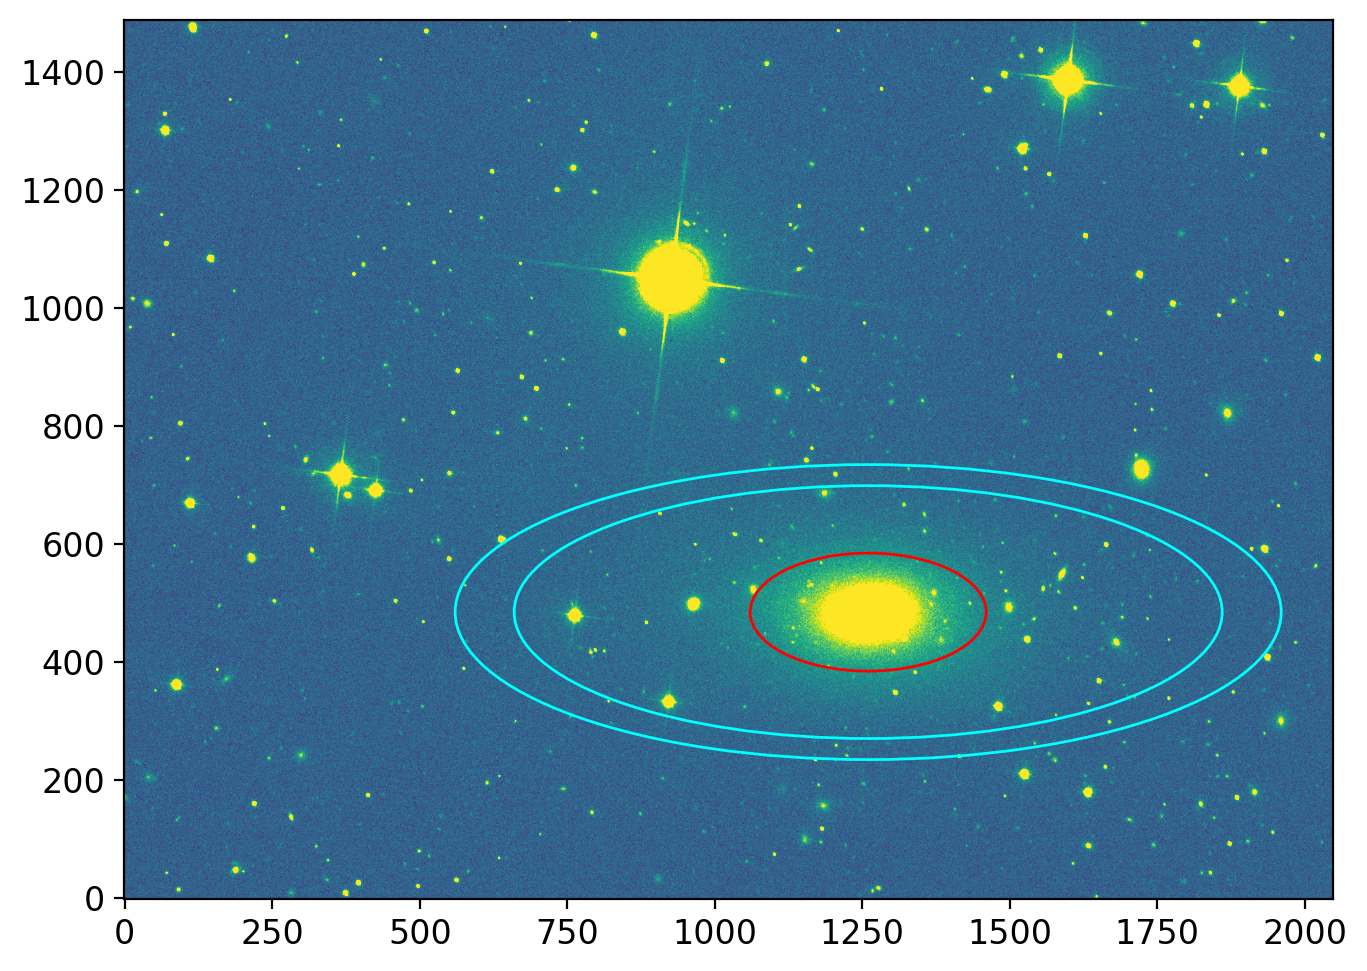

In [3]:
ap = EllipticalAperture(cut.center_original, a=200, b=100, theta=0)
an = EllipticalAnnulus(cut.center_original, a_in=ap.a*3, a_out=ap.a*3.5, b_out=ap.b*2.5)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, data_orig, zscale=True)
ap.plot(axs, color='r')
an.plot(axs, color='cyan')

plt.tight_layout()
plt.show();

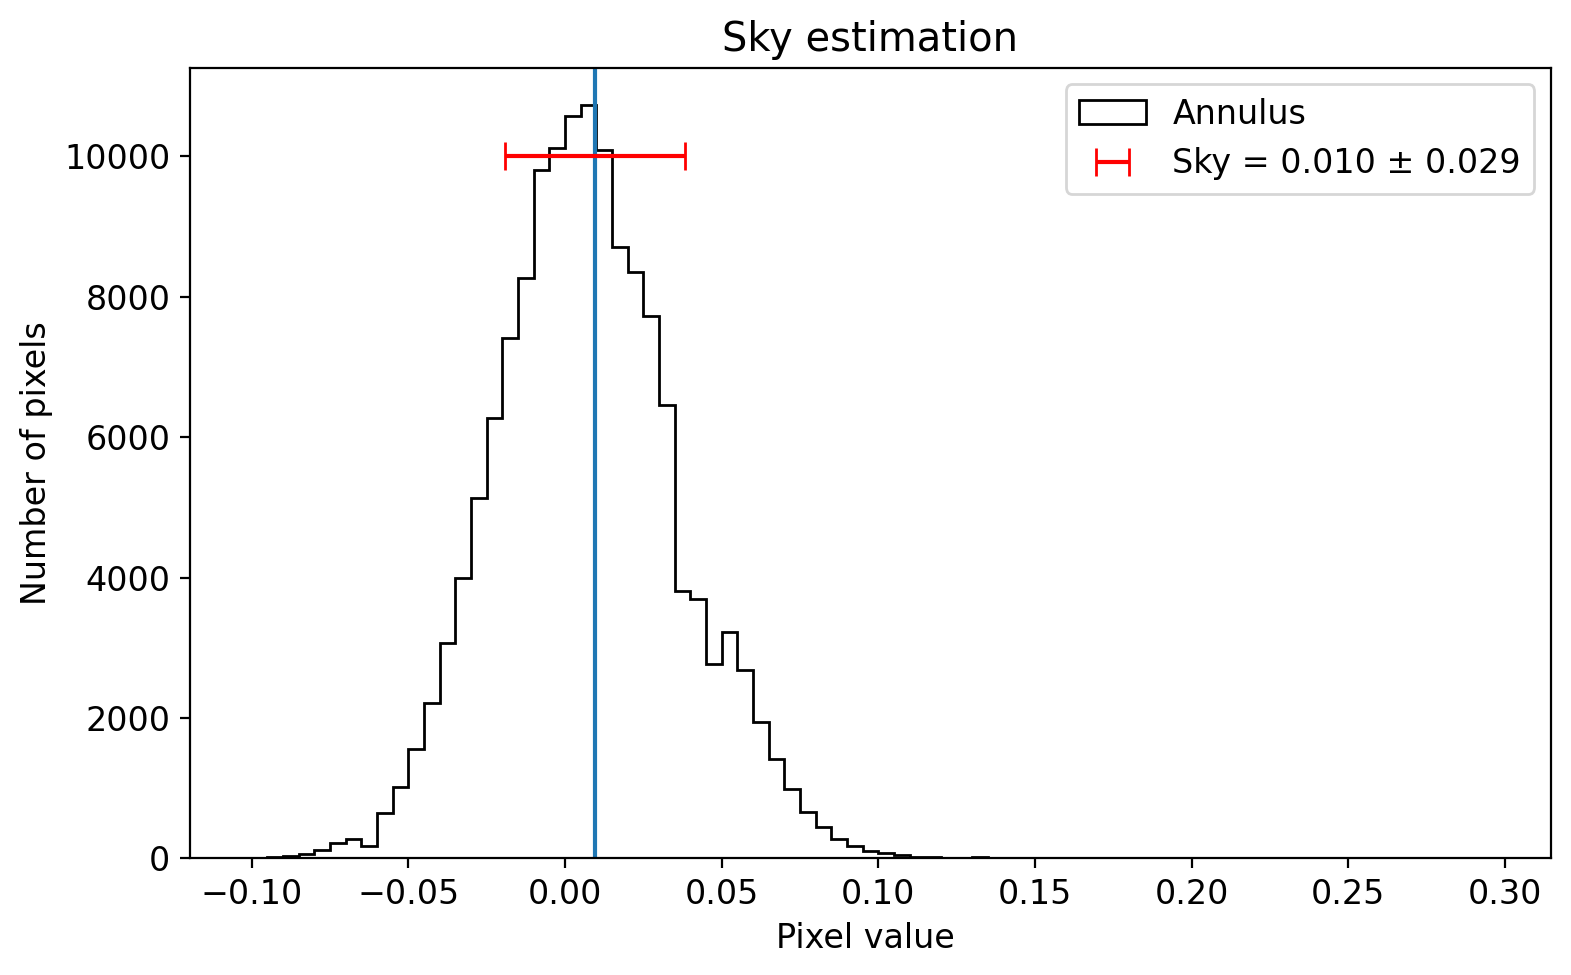

xcenter  ycenter  aperture_sum  aperture_sum_err      msky      ssky  \
0   1260.0    485.0  12544.034143          8.124752  0.009628  0.028734   

     nsky  nrej        aparea    source_sum  source_sum_err        mag  \
0  145088   676  62831.853072  11939.103537       10.857683 -10.192429   

       merr          snr  bad  nbadpix  
0  0.000987  1099.599613    0        0

In [4]:
_data = data_orig.copy()
_data[_data<0] = 0
NMGY = ccd_orig.header["NMGY"]
ccd_error = np.sqrt(_data*NMGY)
phot = ypu.apphot_annulus(data_orig, ap, an, error=ccd_error)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

axs.hist(an.to_mask(method='center').multiply(data_orig, fill_value=np.nan).flatten(), 
         bins=np.arange(-0.1, 0.3, 0.005), histtype='step', color='k', label='Annulus')
axs.axvline(phot["msky"][0])
axs.errorbar(phot["msky"][0], 10000, xerr=phot["ssky"][0], color='r', capsize=5, capthick=1,
             ls="", label=f"Sky = {phot['msky'][0]:.3f} ± {phot['ssky'][0]:.3f}")
axs.set(xlabel="Pixel value ", ylabel="Number of pixels", title="Sky estimation")
axs.legend()
plt.tight_layout()
plt.show();

phot

```{admonition} Error calculation
:class: dropdown, tip
In the error calculation, I ignored negative-valued pixels. Then for positive-valued pixels, I multiplied ``NMGY`` which is explained as ``Calibration factor [nMgy per count]``. Thus, ``pixel/NMGY`` recovers the counts. The poisson noise will be sqrt of this in the unit of counts. Re-converting that to nanomaggy requires a multiplication of ``NMGY``, which means ``error = sqrt(pixsl*NMGY)``.
```

From the sky histogram, although there are some pixel values skewed to the right (due to the stars/objects in the annulus), the mode estimation is reasonable.

However, the two uncomfortable parts are:
1. The contamination of the stars in the aperture. 
    * These are likely the stars in our galaxy. Therefore, you may be overestimating the galaxy's flux. 
2. There is a faint feature of the galaxy extending much further away.
    * How large should the aperture be? If it is too small, we will lose the flux from this galaxy. If it is too large, we will include more stars in the line of sight.

### Radial Profile of Galaxies
One possibility is to find the galaxy's radial profile. If the star's flux is so important, at a certain radius, the profile will show a bump. Otherwise, it will be smoothed out. If we could fit a profile to the data, we could estimate the expected "integral" of flux ($\int_{0}^{\infty} I(r) 2\pi r dr$), and use it as the aperture photometry result.

Elliptical galaxies will roughly follow [De Vaucouleurs profile](https://en.wikipedia.org/wiki/De_Vaucouleurs%27s_law), which is a special case of [Sérsic profile](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile). We can test it by doing photometry for **concentric circular apertures** (I will ignore ellipticity; you may refer to [Ferrari+2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.347..824F/abstract) if you want to know more).

* Algorithm 1: Do photometry to apertures of radius = 1, 2, 3, ..., 100. Then plot ``phot_2 - phot_1``, ``phot_3 - phot_2``, ... , ``phot_100 - phot_99`` at radius of 1.5, 2.5, 3.5, ..., 99.5.
* Algorithm 2: Set up an annulus of inner&outer radii = 1&2, 2&3, 3&4, ..., 99&100. Then find the modal value of each annulus.

Algorithm 1 will be better if there is *no contamination* by field stars because there is no *outlier rejection* involved. Also, the error-analyses will become more tricky (because subtraction of two aperture sums will give roughly $\sqrt{2}$ times the error-bar, while the actual error-bar must be calculated based on pixels within the annulus). 

Algorithm 2 will be robust in such cases because it has outlier rejection included in it (e.g., sigma-clipping). However, one may question if the modal value is THE value we should use for the galaxy's radial profile. I will just proceed with ``"mean"`` for this tutorial, i.e., the sigma-clipped mean.

In the code below, I did this for radii in log space, starting at 6 pixels. This is to ignore the very central region, where there are too few pixels (we also did not do the proper centroiding of the galaxy). Note how I used ``np.ediff1d``. Also note that this is a very simplified way of fitting, and the results may not be robust.

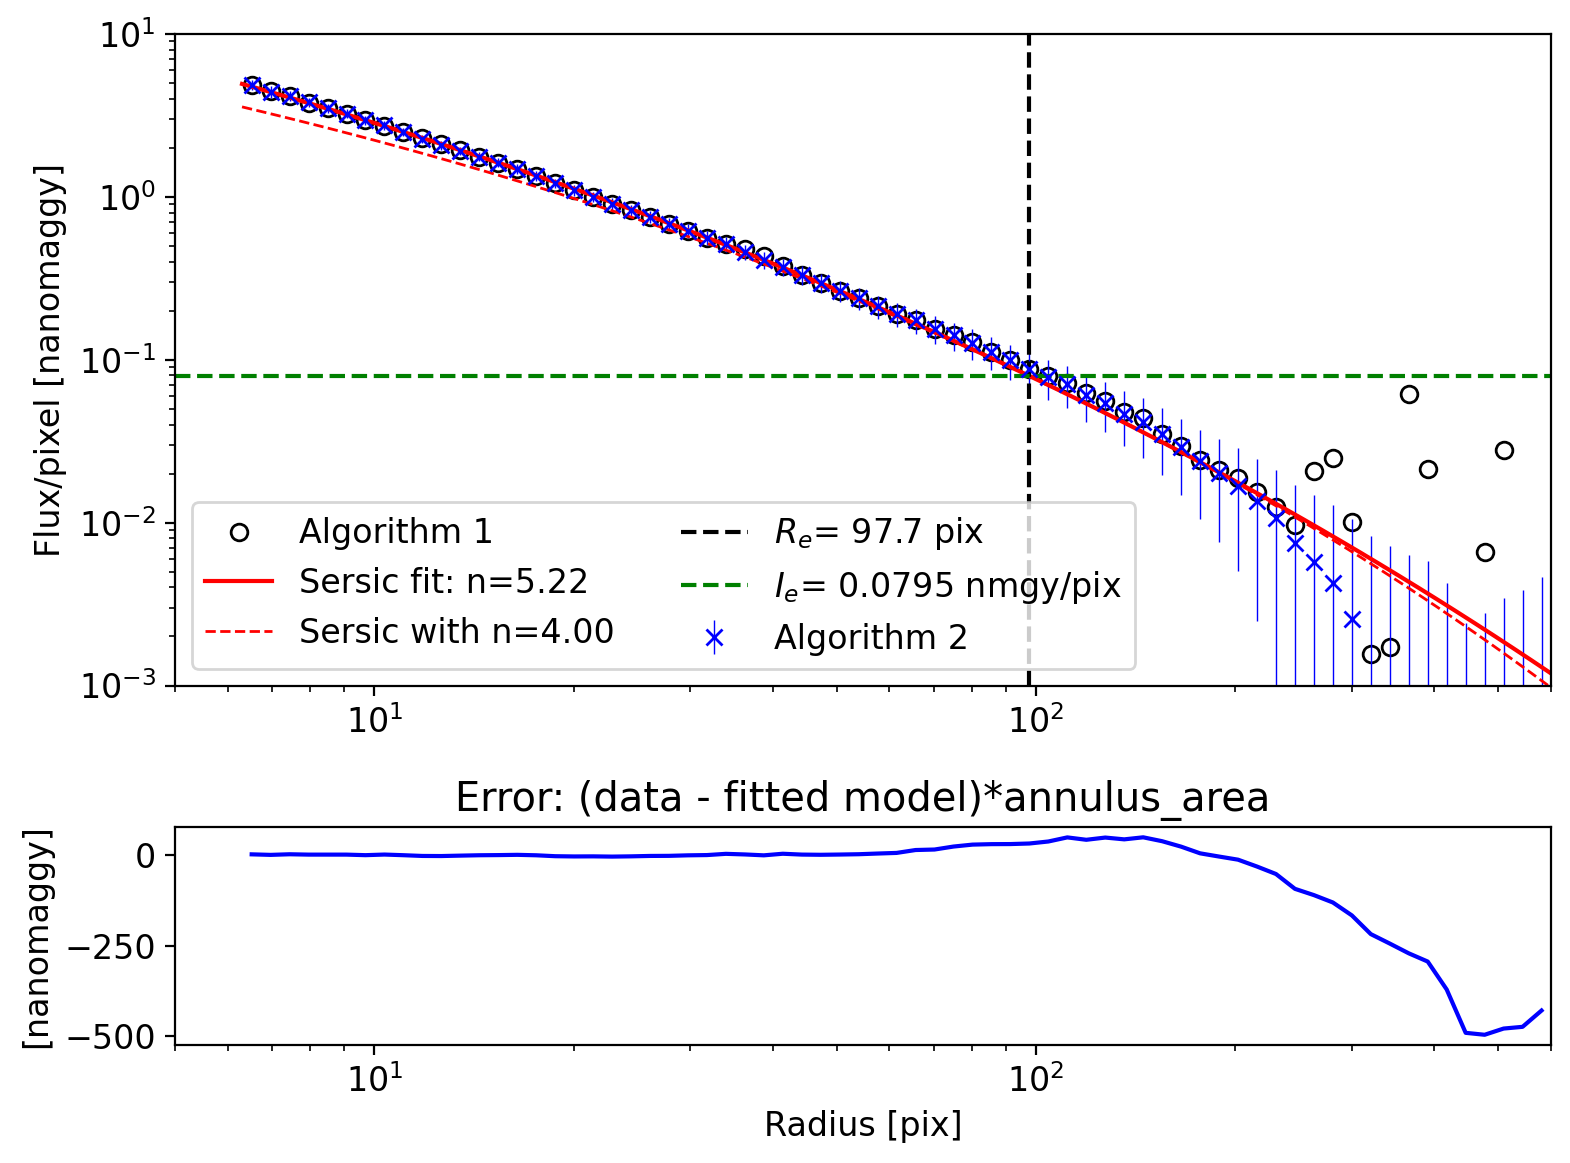

Total source_sum from Sersic profile fitting  : 19567.21
Total source_sum from elliptical aperture phot: 11939.10 (radius = (200.0 100.0)


In [5]:
def sersic(r, i_e=1, r_e=1, n=4):
    return i_e * np.exp(-ss.gammaincinv(2*n, 0.5) * ((r/r_e)**(1/n) - 1))


def sersic_lum(i_e=1, r_e=1, n=4):
    """Total luminosity of the Sersic profile (integral)"""
    bn = ss.gammaincinv(2*n, 0.5)
    g2n = ss.gamma(2*n)
    return i_e * r_e**2 * 2*np.pi*n * np.exp(bn)/(bn**(2*n)) * g2n


radii = np.logspace(0.8, np.log10(an.a_in), 70)
radii_plot = radii[:-1] + np.ediff1d(radii)/2

aps1 = [CircularAperture(cut.center_original, r) for r in radii]
phots1 = ypu.apphot_annulus(data_orig, aps1, annulus=an, error=ccd_error)
# Do the photometry using the annulus defined above

phots2 = []
phots2_err = []
for i, r in enumerate(radii[:-1]):
    _an = CircularAnnulus(cut.center_original, r_in=r, r_out=radii[i+1])
    _phot = ypu.sky_fit(data_orig, _an, method="mean", sigma=3, maxiters=5, to_table=False)
    phots2.append(_phot["msky"] - phot["msky"][0])
    # Subtract the sky value found above
    phots2_err.append(np.sqrt(_phot["ssky"]**2/_phot["nsky"] + _phot["msky"]*NMGY))
    # first term = sky estimation error, second term = Poisson error from the estimated sky
phots2 = np.array(phots2)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": (3, 1)})

popt, _ = curve_fit(sersic, xdata=radii_plot, ydata=phots2, 
                    sigma=phots2_err, absolute_sigma=True)
axs[0].plot(radii_plot, np.ediff1d(phots1['source_sum'])/np.ediff1d(phots1["aparea"]),
            'ko', mfc="none", label='Algorithm 1')
axs[0].errorbar(radii_plot, phots2, yerr=phots2_err, color="b", elinewidth=0.5,
                marker="x", ls="", mfc="none", label='Algorithm 2')
axs[0].set(xscale='log', yscale="log", ylabel="Flux/pixel [nanomaggy]",
           xlim=(5, an.a_in), ylim=(1.e-3, 1.e+1))
axs[0].plot(radii, sersic(radii, *popt), 'r-', label=f'Sersic fit: n={popt[2]:.2f}')
axs[0].plot(radii, sersic(radii, popt[0], popt[1], 4), 'r--', label=f'Sersic with n=4.00', lw=1)
axs[0].axvline(popt[1], color="k", ls="--", label=f"$R_e$= {popt[1]:.1f} pix")
axs[0].axhline(popt[0], color="g", ls="--", label=f"$I_e$= {popt[0]:.4f} nmgy/pix")
axs[0].legend(loc=3, ncol=2)

axs[1].errorbar(radii_plot, (phots2-sersic(radii_plot, *popt))*np.ediff1d(phots1["aparea"]), 
                yerr=phots2_err, color="b", elinewidth=0.5,)
axs[1].set(xscale='log', xlabel="Radius [pix]", ylabel="[nanomaggy]", 
           title="Error: (data - fitted model)*annulus_area",
        #    ylim=(-0.1, 0.1), 
           xlim=(5, an.a_in))
plt.tight_layout()
plt.show()

print(f"Total source_sum from Sersic profile fitting  : {sersic_lum(*popt):.2f}")
print(f"Total source_sum from elliptical aperture phot: {phot['source_sum'][0]:.2f}"
      + f" (radius = ({ap.a:.1f} {ap.b:.1f})")

Note that the total flux from the elliptical aperture is indeed **smaller** than that estimated from the Sersic profile integration because we could not take flux outside our aperture into account. However, as you can see from the fitting residual, the Sersic profile greatly overestimates the flux of our galaxy, especially because it **overestimates** flux at the outskirts of the galaxy. 

I emphasize again that the code used here is extremely crude. If you are conducting serious research, it is your responsibility to use proper code, deal with uncertainties (the ``curve_fit`` I used here is only the most crude approximation of good fitting), discuss the results mathematically and scientifically, etc.

```{admonition} Practice
:class: tip
* What happens if you change to ``method="mean"`` for `sky_fit`?
* What happens if you change to ``sigma=2`` for `sky_fit`? Why do you think this happens?
* What happens if you remove ``/np.sqrt(_phot["nsky"])`` in the error calculation line? Do you think the resulting error-bars are reasonable? Why or why not?
```

## Ellipse (STSDAS.ISOPHOT.ELLIPSE)
You learned the [photutils/ELLIPSE Isophote analysis](https://photutils.readthedocs.io/en/stable/isophote.html). I will not go into details in this lecture note. For the projects, you may also refer to them.

## Overlapping Objects
When there is a supernova, field star in the line of sight, asteroid/comet, or variable **overlapped** with the galaxy, how do you do the photometry?

The simplest strategy: `image - GalaxyProfile` and do the photometry.

Here, I will demonstrate ELLIPSE model subtraction.

First, set the initial model (white contour): 

In [68]:
from photutils.isophote import EllipseGeometry
geometry = EllipseGeometry(
    x0=pos_init[0], y0=pos_init[1], sma=20, eps=0.5, pa=np.deg2rad(5)
)
ellipse = Ellipse(data_orig, geometry)

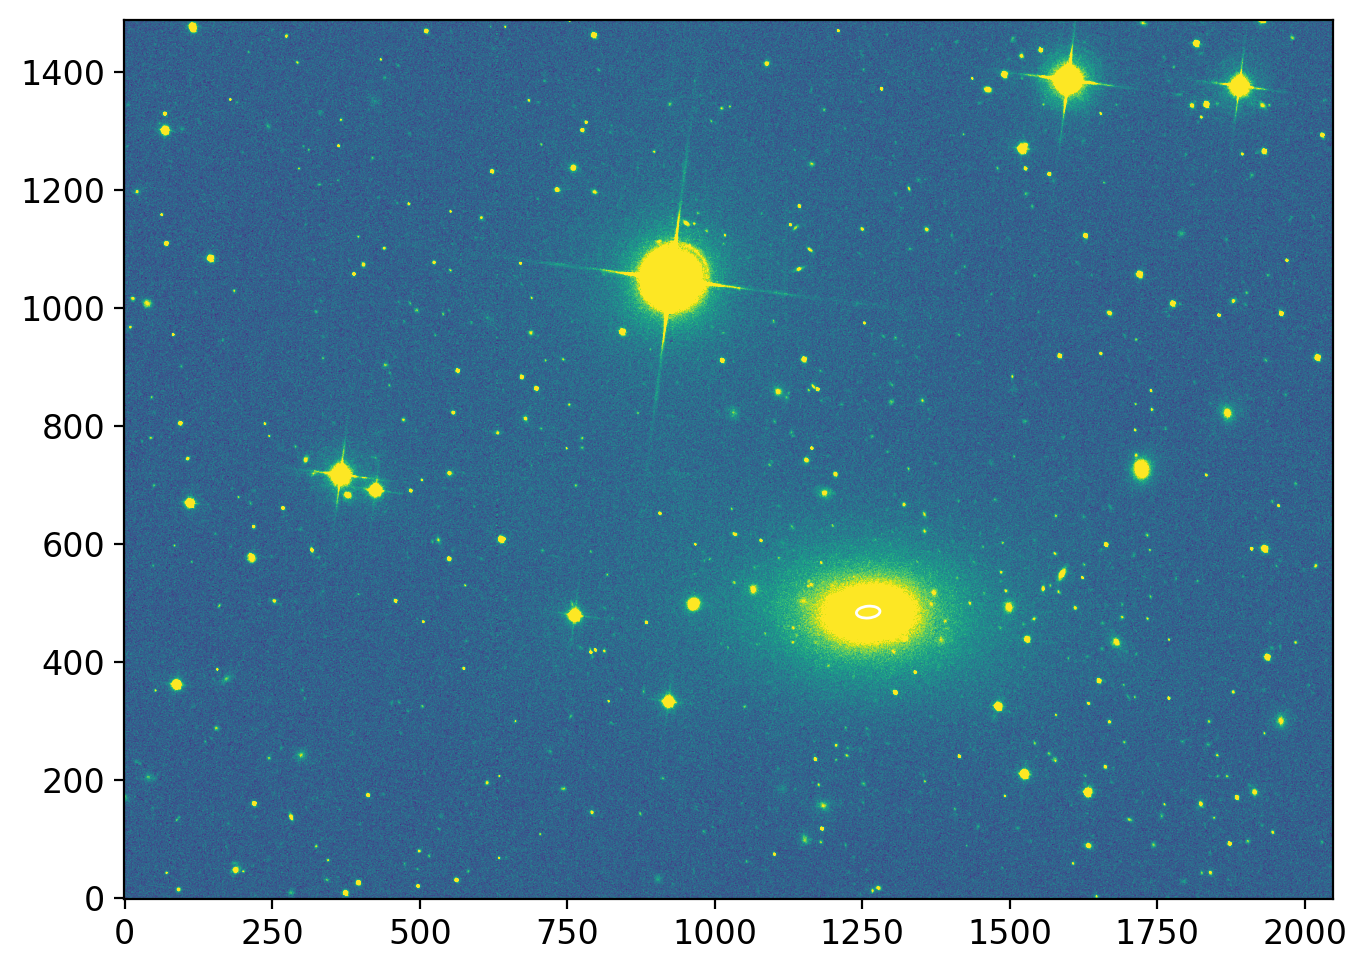

In [69]:
aper = EllipticalAperture(
    (geometry.x0, geometry.y0), geometry.sma,
    geometry.sma * (1 - geometry.eps), geometry.pa
)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(ax, data_orig, zscale=True)
aper.plot(color='white')

plt.tight_layout()
plt.show();

Then fit the ELLIPSEs to the image, and build the ELLIPSE model to subtract the galaxy (it takes ~ 20 sec on MBP 14" [2021, macOS 13.1, M1Pro(6P+2E/G16c/N16c/32G)]):

In [76]:
isolist = ellipse.fit_image(maxsma=None)
isodf = isolist.to_table().to_pandas()

model_image = build_ellipse_model(data_orig.shape, isolist)
residual = data_orig - model_image

Check the fitted ELLIPSEs:

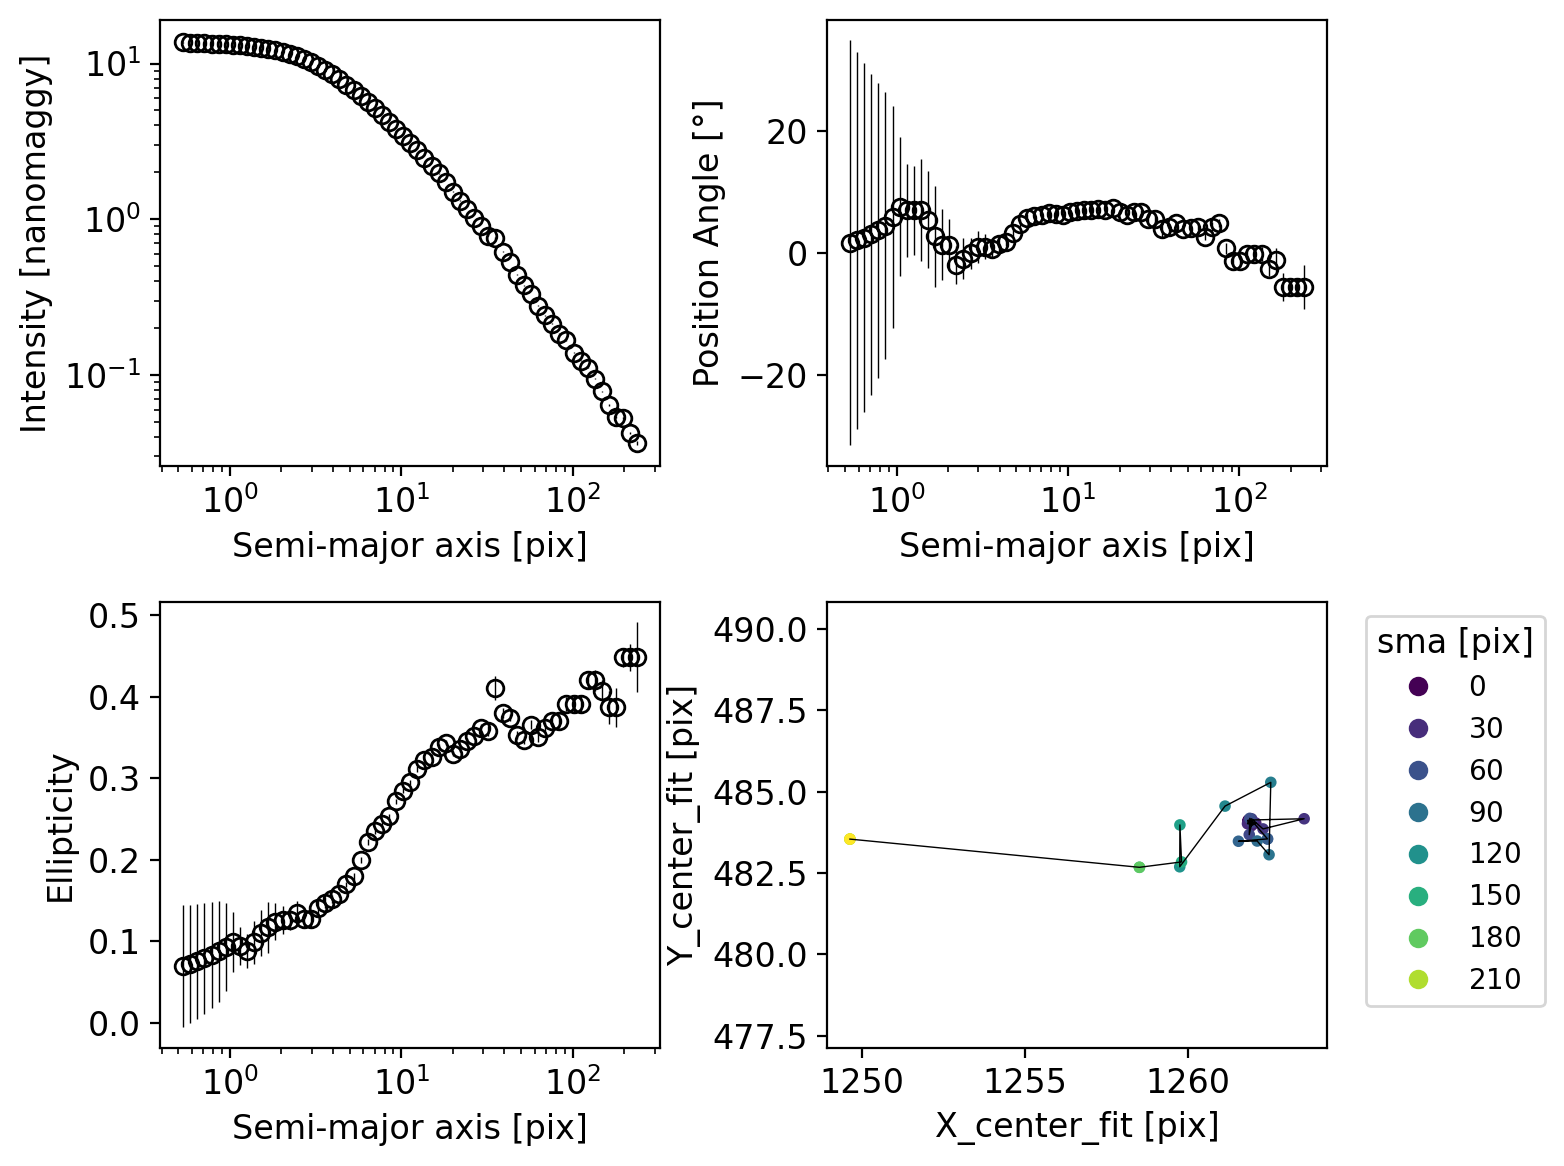

In [77]:
fig, axs = plt.subplots(2,2, figsize=(8, 6))

isodf.pa = (isodf.pa + 90) % 180 - 90  # convert to [-90, 90]

errbkw = dict(color="k", elinewidth=0.5, marker="o", ls="", mfc="none")
axs[0, 0].errorbar(isodf.sma, isodf.intens, yerr=isodf.intens_err, **errbkw)
axs[0, 1].errorbar(isodf.sma, isodf.pa, yerr=isodf.pa_err, **errbkw)
axs[1, 0].errorbar(isodf.sma, isodf.ellipticity, yerr=isodf.ellipticity_err, **errbkw)
axs[1, 1].plot(isodf.x0, isodf.y0, "k-", lw=0.5)
sc = axs[1, 1].scatter(isodf.x0, isodf.y0, c=isodf.sma, cmap="viridis", marker="o", s=10)
axs[0,0].set(xscale='log', yscale="log", xlabel="Semi-major axis [pix]", ylabel="Intensity [nanomaggy]")
axs[0,1].set(xscale='log', xlabel="Semi-major axis [pix]", ylabel="Position Angle [°]")
axs[1,0].set(xscale='log', xlabel="Semi-major axis [pix]", ylabel="Ellipticity")
axs[1,1].legend(*sc.legend_elements(), title="sma [pix]", loc=2, 
                fontsize=10, bbox_to_anchor=(1.05, 1))
axs[1,1].set(xlabel="X_center_fit [pix]", ylabel="Y_center_fit [pix]")
axs[1,1].set_aspect("equal", "datalim")
plt.tight_layout()
plt.show();

Text(0.5, 1.0, 'Residual')

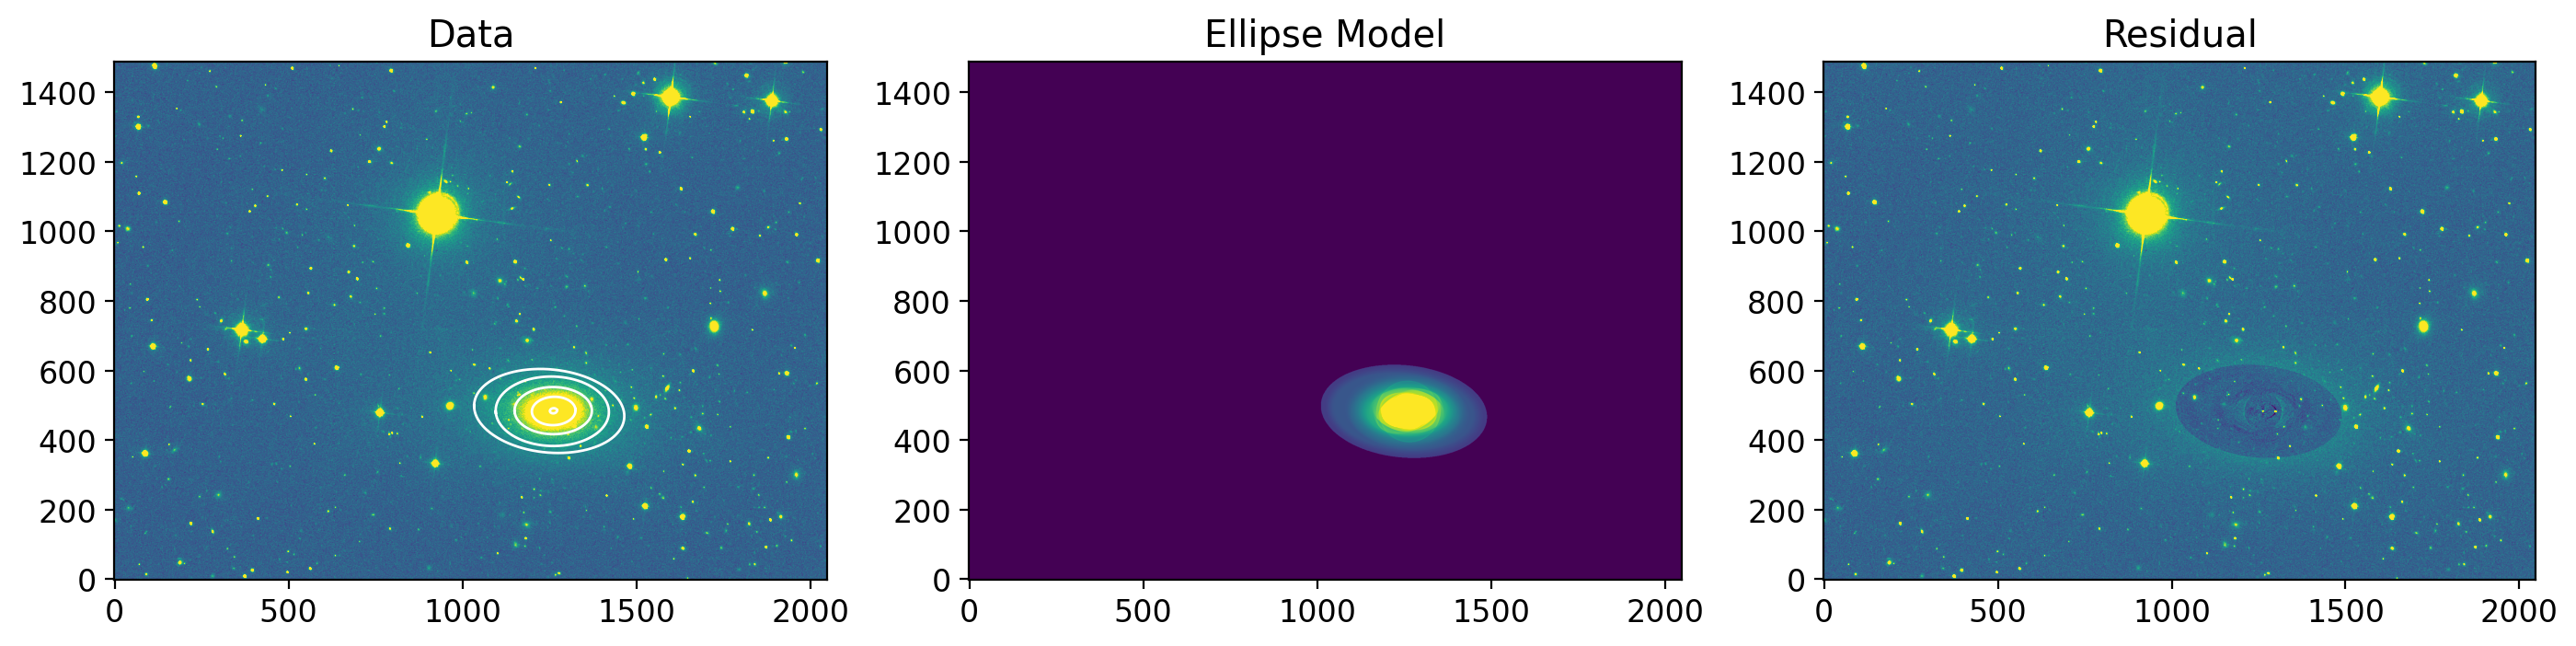

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
vis.norm_imshow(ax1, data_orig, zscale=True)
ax1.set_title('Data')

smas = np.arange(10, isodf.sma.max(), 50)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white', lw=1)

vis.norm_imshow(ax2, model_image, vmin=0, vmax=0.2, stretch='sqrt')
# ax2.imshow(model_image, origin="lower", vmin=0, vmax=10)
ax2.set_title('Ellipse Model')

vis.norm_imshow(ax3, residual, zscale=True)
ax3.set_title('Residual')

Residual data cutout:

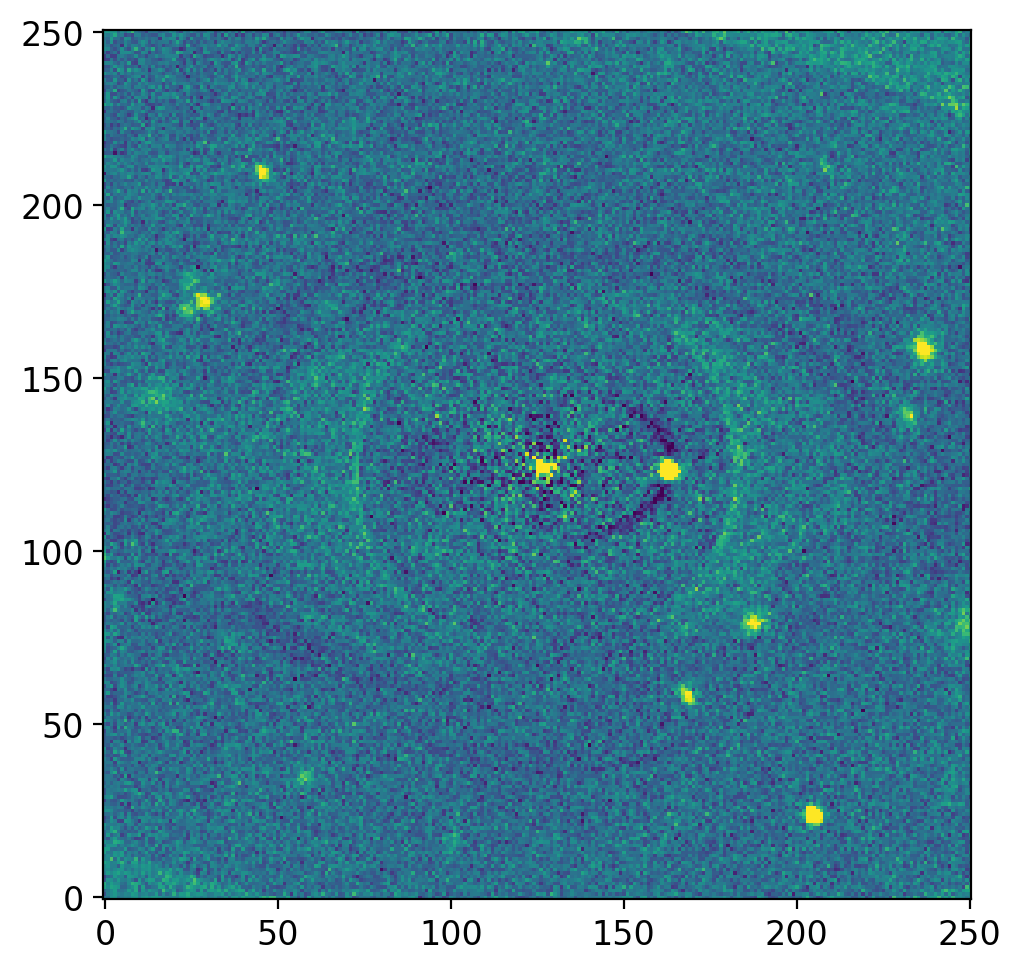

In [89]:
ccd_res = ccd_orig.copy()
ccd_res.data -= model_image
cut_res = Cutout2D(ccd_res, position=pos_init, size=(251, 251))
data_res = cut_res.data
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, data_res, zscale=True)
plt.tight_layout()
plt.show();

Now you may see the bright object at around (160, 120). In this way, you can do the photometry of the "object overlapping with an extended source". 

* Note: I have no idea what that bright source is --- it is neither of my research interest nor important for this practice course.

* Note: You may see some oversubtracted regions in the residual. One may develop a pipeline that iteratively does ELLIPSE fitting and subtraction, finding the target of desired and masking that region to get a better fitting.